In [1]:
__author__ = 'Shi Fan, Federica Bianco'
import glob
import pandas as pd
import numpy as np
import pylab as pl
import os
%pylab inline
from scipy import signal
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


/Users/fbianco/UIdata/


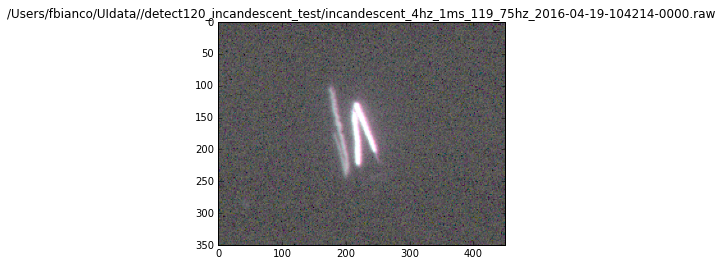

In [2]:
int_times = [1]
cam_cadence = {"4":4,"3p1":3.1,"3p5":3.5}
from scipy.ndimage.filters import median_filter

# setting values for image dimension early on
nrow = 1080 
ncol = 1920
nband = 3

PICKLE = False
#PICKLE = True
REREAD=False
REREAD=True
#FBB adding env variable so it is easy to run on different machines
datapath=os.getenv('UIdata')
print (datapath)
if not datapath:
    datapath = '/scratch/share/dm3805'
    print (datapath)

if REREAD:
    
    photos = {}

    for i,c in enumerate(cam_cadence.keys()):
        path = datapath+'/detect120_incandescent_test/in*%shz_1ms_119_75hz*.raw' % c
        
        
        photos[c] = glob.glob(path)

        
    #Converting series into Numpy arrays
    photo_arr = {}
    

    for key, value in photos.iteritems():
        photo_arr[key] = np.array(value)[np.argsort(value)] 
        
    #median_filter?
    median_filter(255*pow((1.0/255.0*np.fromfile(photo_arr["4"][i], dtype=np.uint8)),1.0/6), footprint=(2,2,0))
    for i in range(1):
        pl.figure()
        pl.title(photo_arr["4"][i])
        pl.imshow((median_filter(255*pow((1.0/255.0*np.fromfile(photo_arr["4"][i], dtype=np.uint8)),1.0/3), 
                                 footprint=(6,6,0))).clip(0,255).astype(np.uint8).reshape(nrow,ncol, nband)[200:550,750:1200])
        pl.savefig("")

In [3]:
mask = 300,450,950,1000
pickle_path = os.getenv("UIdata")+"/ht_pickles"#'/scratch/share/fbianco/ht_pickles'
#pickle_path = 'ht_pickles'

if REREAD:
    photo_resized = {}
    
    # initialization
    for key, value in photo_arr.iteritems():
        photo_resized[key] = np.zeros(len(value))
    # close range
    for r in photo_resized:
        for i,f in enumerate(photo_arr[r]):
            photo_resized[r][i] = sum(np.fromfile(f,dtype=np.uint8).reshape(nrow,ncol,nband)[mask[0]:mask[1],mask[2]:mask[3]]) 
        print r
    if PICKLE: pkl.dump(photo_resized, open(pickle_path+'/filament.pkl', 'wb'))
    
else:
    pklfiles = glob.glob(datapath+'/ht_pickles/filament.pkl')[0]
    photo_resized = pkl.load(open(pklfiles, 'rb'))

3p1
4
3p5


In [45]:
#function definitions
#we like them altogether so we can easily find a function definition when we need to

def mynorm(flux):
    flux -= flux.mean()
    return 2*(flux-flux.min())/(flux.max()-flux.min())
        
def plot_flux_by_runtime(flux, c_freq, runtime, fftax):
    pl.figure(figsize=(20,5))
        
    color = 'dodgerblue'
    pl.title('Close-up Flux: Shutter 119.75Hz; Camera '+str(c_freq)+'Hz; Integration 1ms', fontsize=20)
    pl.plot(runtime, flux, '-', color=color, linewidth=0.75)
    pl.plot(runtime, flux, 'o', color=color)
    #pl.xlim(0,125)
        
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Almost normalized flux", fontsize=15)
    pl.ylim(-.1,2.1)
    
    pl.figure(figsize=(20,5))

    freq = np.fft.rfftfreq(len(flux), d=1.0/c_freq)

    fftax.plot(freq, np.abs(np.fft.rfft(flux)), alpha=0.5, label='%f'%c_freq)

def folding(flux, runtime, freq):
    runtime_mod = np.mod( runtime, 2.0/freq)
    return flux, runtime_mod # return time in microseconds

def sine_wave(time, freq, mag=1, phase=0):
    wave = mag*np.sin(2*np.pi*freq*time+phase)+mag
    return wave


def camera_meets_shutter_wave(time, cam, s_freq):
    #simplified for this particular case
    if time.shape!=cam.shape:
        print ('Time series must have the same length as camera wave')
    
    return sine_wave(time, float(s_freq))*cam

## Setting up data

In [41]:
#Creating dictionaries for flux
#Normalizing flux by (flux-mean)/std

flux = {}
runtime = {}

for key, value in photo_resized.iteritems():
    print key
    flux[key] = mynorm(value)
    
    
    runtime[key] = np.arange(0, len(value)*cam_cadence[key], cam_cadence[key])

3p1
4
3p5


## Flux vs time

In [42]:
for key in flux.keys():
    print key

3p1
4
3p5


In [43]:
for key in flux.keys(): 
    print cam_cadence[key], len(flux[key]), len(runtime[key]),

3.1 800 800 4 503 503 3.5 1000 1000


800 800
503 503
1000 1000


(0, 300)

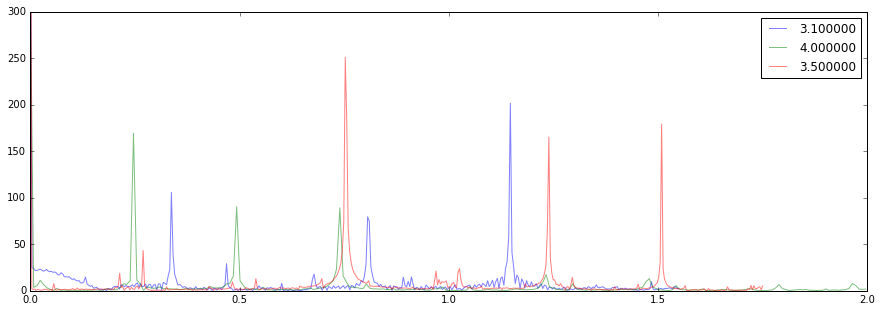

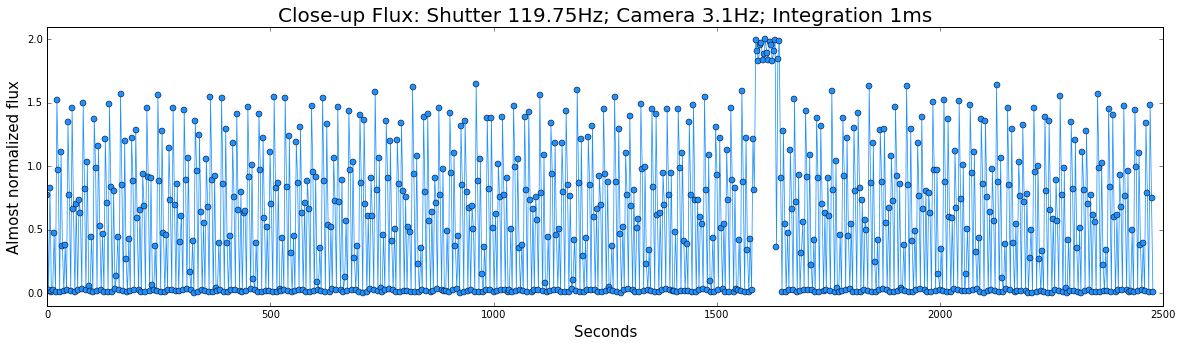

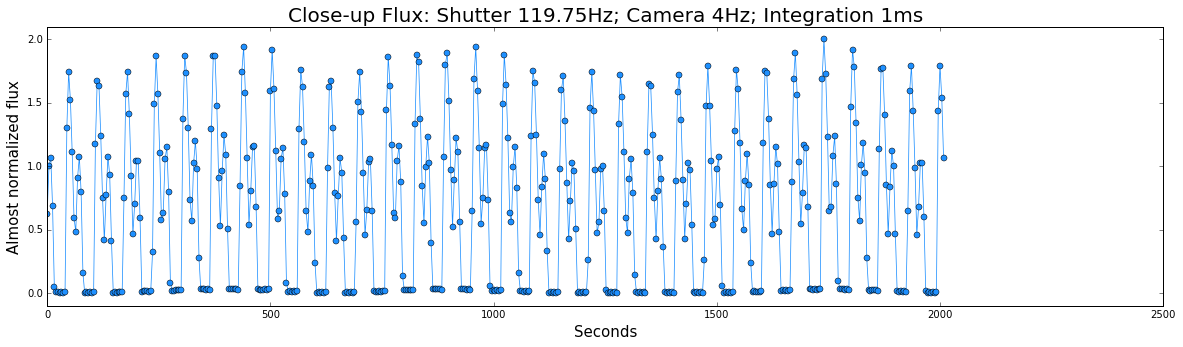

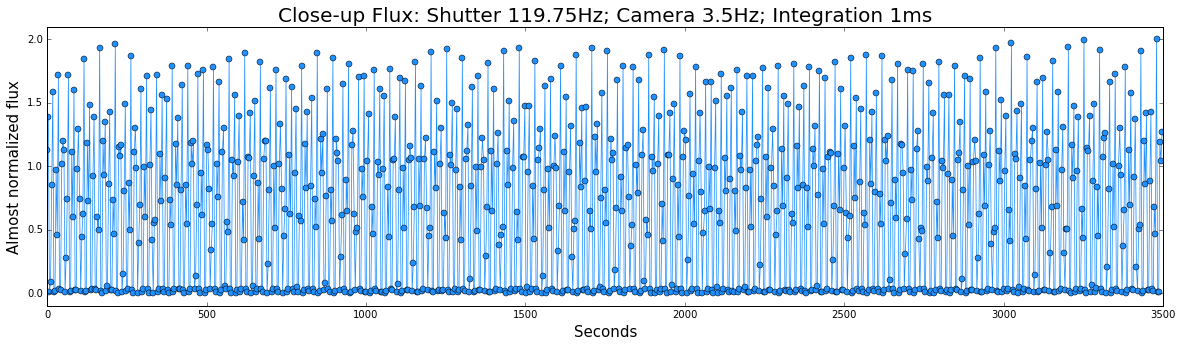

In [47]:
fftax = pl.figure(figsize=(15,5)).add_subplot(111)
for key,fl in flux.iteritems():  
    print len(fl), len(runtime[key])
    plot_flux_by_runtime(fl, cam_cadence[key], 
                         runtime[key],fftax)
fftax.legend()
fftax.set_ylim(0,300)

## Folded flux (2 shutter cycles)

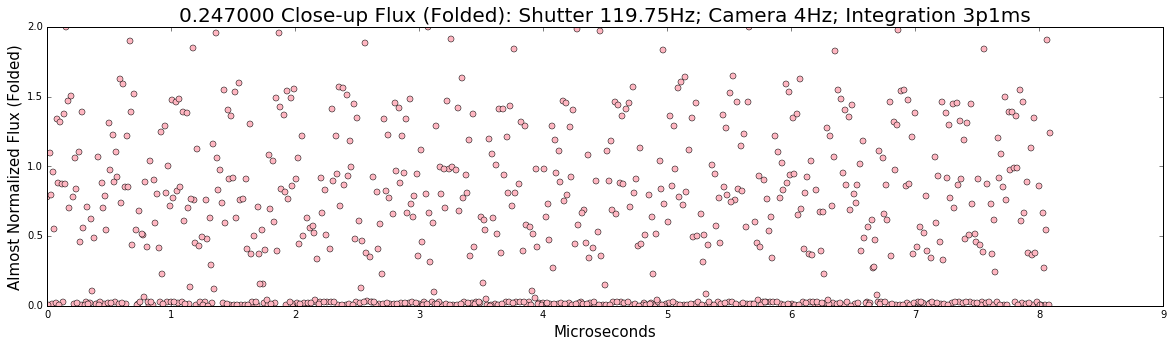

In [50]:
folded = {}
expected_freqs =[0.247]#np.arange(0.245,0.255,0.0001)
for key, value in flux.iteritems():
    if not key == "3p1": continue
    for expected_freq in expected_freqs:
        folded[key] = {}
        folded[key]['flux'], folded[key]['time'] = folding(value, 
                                                           runtime[key], 
                                                           expected_freq)
    
        pl.figure(figsize=(20,5))
        #pl.plot(folded[key]['time'], folded[key]['flux'], '-', 
        #    color='lightpink', linewidth=0.75)
        pl.plot(folded[key]['time'], folded[key]['flux'], 'o', 
            color='lightpink')
        pl.xlabel("Microseconds", fontsize=15)
        pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
        pl.title('%f Close-up Flux (Folded): Shutter 119.75Hz; Camera 4Hz; Integration '%expected_freq+str(key)+'ms', fontsize=20)
        #pl.xlim(0,2/expected_freq)
        pl.show()

## Testing for the best-fitting folding frequency

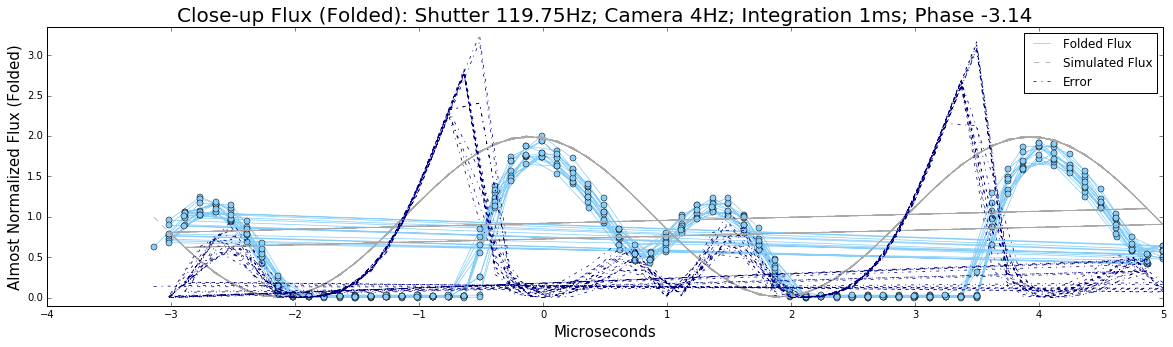

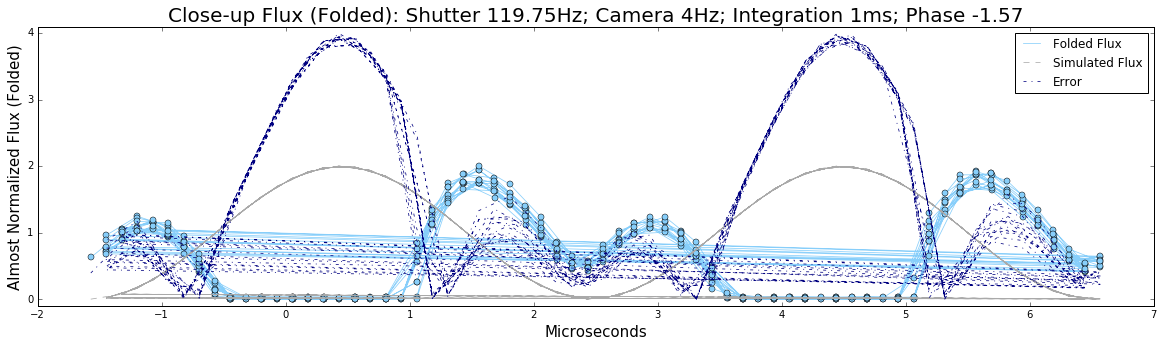

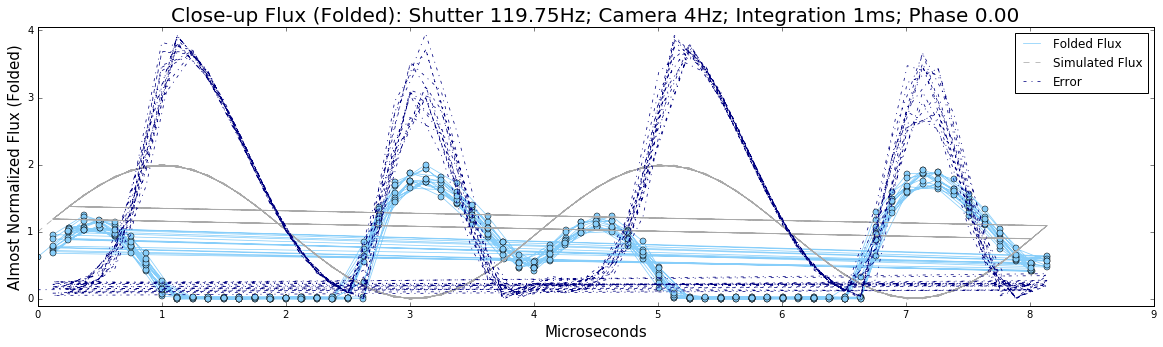

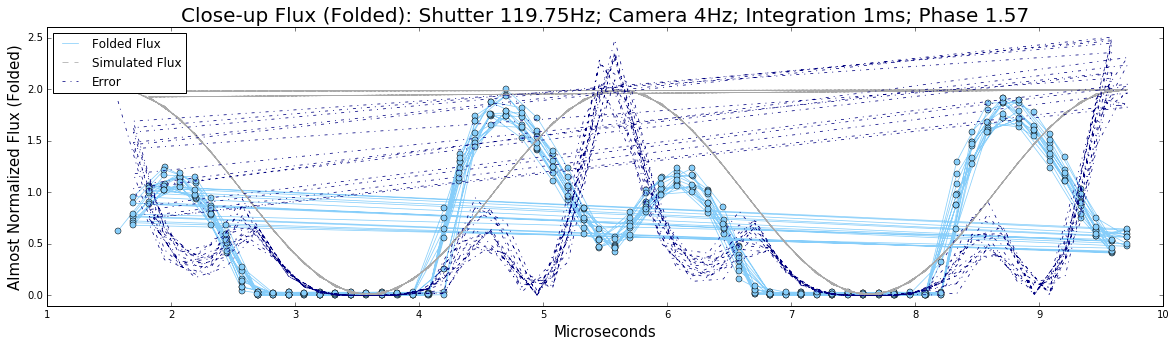

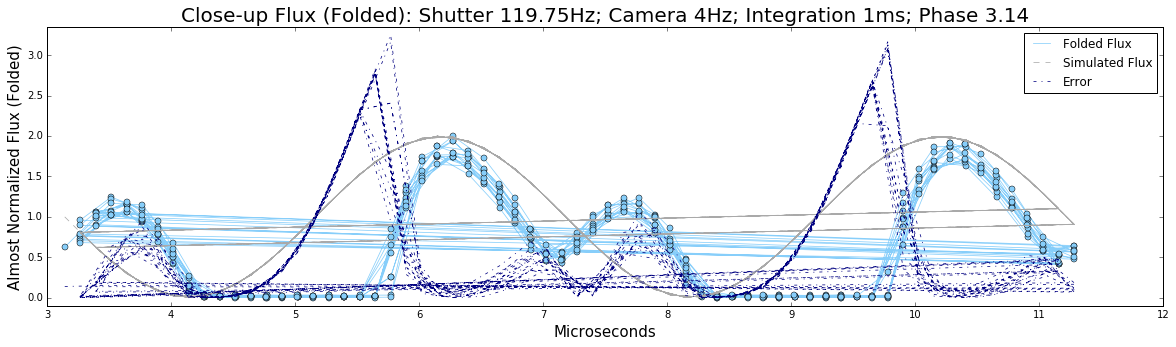

In [28]:
for phase in np.arange(-np.pi, np.pi+.01, np.pi/2):
    time_arr = folded_close["4"]['time']+phase
    sine_arr = sine_wave(folded_close["4"]['time'], 0.2475, mag=1, phase=phase)
    pl.figure(figsize=(20,5))
    pl.plot(time_arr, folded_close["4"]['flux'], '-', c='lightskyblue', lw=0.75, label='Folded Flux')
    pl.plot(time_arr, folded_close["4"]['flux'], 'o', c='lightskyblue')
    pl.plot(time_arr, sine_arr, '--', color='darkgrey', linewidth = 0.75, label='Simulated Flux')
    pl.plot(time_arr, (sine_arr-folded_close["4"]['flux'])**2, '-.', c='navy', lw=0.75, label='Error')
    pl.legend(loc='best')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Close-up Flux (Folded): Shutter 119.75Hz; Camera 4Hz; Integration 1ms; Phase %.2f'%phase, fontsize=20)
    temp_max = np.max(np.array([np.max(folded_close["4"]['flux']), np.max(sine_arr), np.max((sine_arr-folded_close["4"]['flux'])**2)]))
    pl.ylim(-.1,temp_max+.1)
    pl.show()

In [29]:
def minimizer(phase, data, time, freq, mag):
    return sum((data-sine_wave(time, freq, mag, phase))**2)

In [35]:
from scipy.optimize import leastsq

optimal_phases = {'close':[], 'mid':[]}
phases = np.arange(-np.pi, np.pi+.01, np.pi/5)
phase_idx_close = []

rss_close = {}
phases = np.arange(-np.pi, np.pi+.01, np.pi/5)
for key, value in folded_close.iteritems():
    rss_close[key] = []
    for phase in phases:
        time_arr = value['time']+phase
        sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=phase)
        rss_close[key].append(np.sum((value['flux']-sine_arr)**2))
   
phase_idx_close = []
for key, value in rss_close.iteritems():
    phase_idx_close.append(np.argmin(np.array(value)))


cnt=0
for key, value in folded_close.iteritems():
    phase = phases[phase_idx_close[cnt]]
    flux = value['flux']; time = value['time']
    result = leastsq(minimizer, phase, args=(flux, time, 0.2475, 1))
    optimal_phases['close'].append(result[0][0])
    cnt+=1

In [38]:
cnt=0
for key, value in folded_close.iteritems():
    # get phase
    pre_mini_opt_phase = phases[phase_idx_close[cnt]]
    post_mini_opt_phase = optimal_phases['close'][cnt]
    # get simulated sine wave
    pre_mini_sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=pre_mini_opt_phase)
    post_mini_sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=post_mini_opt_phase)
    # get rss
    print 'For close-up flux with %shz, is our phase returned by scipy function better than the previous estimate?'%(key)
    print np.sum((value['flux']-pre_mini_sine_arr)**2)>np.sum((value['flux']-post_mini_sine_arr)**2)
    print
    cnt+=1

For close-up flux with 4hz, is our phase returned by scipy function better than the previous estimate?
True



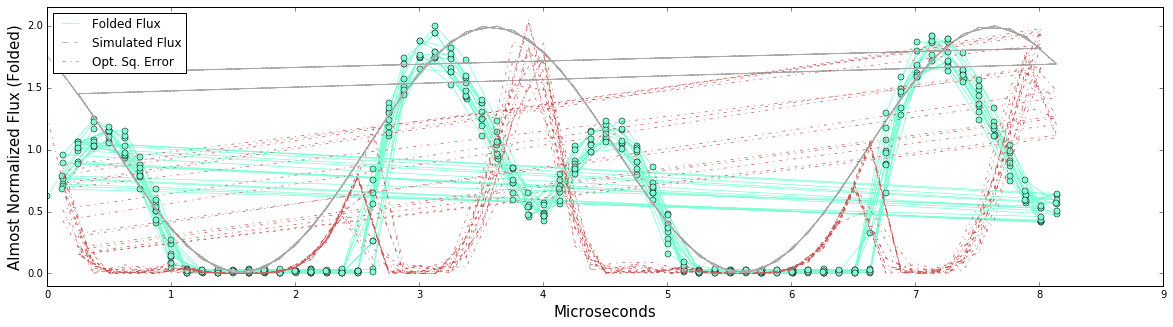

In [40]:
cnt = 0
for key, value in folded_close.iteritems():
    phase = optimal_phases['close'][cnt]
    sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=phase)
    pl.figure(figsize=(20,5))
    pl.plot(value['time'], value['flux'], '-', c='aquamarine', lw=0.75, label='Folded Flux')
    pl.plot(value['time'], value['flux'], 'o', c='aquamarine')
    pl.plot(value['time'], sine_arr, '--', color='darkgrey', lw = 0.75, label='Simulated Flux')
    pl.plot(value['time'], (sine_arr-value['flux'])**2, '-.', c='indianred', lw=0.75, label='Opt. Sq. Error')
    pl.legend(loc='best')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    temp_max = np.max(np.array([np.max(value['flux']), np.max(sine_arr), np.max((sine_arr-value['flux'])**2)]))
    pl.ylim(-.1,temp_max+.1)
    pl.show()
    cnt+=1